In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing
from copy import deepcopy

import jax
import jax.numpy as jnp

import numpyro
import numpyro.infer
# import render
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam, TransformReparam
from numpyro.contrib.control_flow import scan

import arviz as az

In [2]:
from lfo_cv import compute_reloo

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from numpyro.handlers import condition, seed, substitute, trace
from jax import random

In [7]:
# from models import drift_perseverance_model, fit
# from models import generate_pooled_model
# from models import generate_pooled_model_onpolicy
# from models import generate_onpolicy_model
from models import fit
from mechanistic_models import generate_mechanistic_model as generate_onpolicy_model

In [314]:
import itertools
from pathlib import Path

import jax

from numpyro import handlers
import numpyro.distributions as dist


def get_model_relations(model, model_args=None, model_kwargs=None, num_tries=10):
    """
    Infer relations of RVs and plates from given model and optionally data.
    See https://github.com/pyro-ppl/numpyro/issues/949 for more details.
    This returns a dictionary with keys:
    -  "sample_sample" map each downstream sample site to a list of the upstream
       sample sites on which it depend;
    -  "sample_dist" maps each sample site to the name of the distribution at
       that site;
    -  "plate_sample" maps each plate name to a lists of the sample sites
       within that plate; and
    -  "observe" is a list of observed sample sites.
    For example for the model::
        def model(data):
            m = numpyro.sample('m', dist.Normal(0, 1))
            sd = numpyro.sample('sd', dist.LogNormal(m, 1))
            with numpyro.plate('N', len(data)):
                numpyro.sample('obs', dist.Normal(m, sd), obs=data)
    the relation is::
        {'sample_sample': {'m': [], 'sd': ['m'], 'obs': ['m', 'sd']},
         'sample_dist': {'m': 'Normal', 'sd': 'LogNormal', 'obs': 'Normal'},
         'plate_sample': {'N': ['obs']},
         'observed': ['obs']}
    :param callable model: A model to inspect.
    :param model_args: Optional tuple of model args.
    :param model_kwargs: Optional dict of model kwargs.
    :param int num_tries: Optional number times to trace model to detect
        discrete -> continuous dependency.
    :rtype: dict
    """
    model_args = model_args or ()
    model_kwargs = model_kwargs or {}

    trace = handlers.trace(handlers.seed(model, 0)).get_trace(
        *model_args, **model_kwargs
    )
    obs_sites = [
        name
        for name, site in trace.items()
        if site["type"] == "sample" and site["is_observed"]
    ]

    def _get_dist_name(fn):
        if isinstance(
            fn, (dist.Independent, dist.ExpandedDistribution, dist.MaskedDistribution)
        ):
            return _get_dist_name(fn.base_dist)
        return type(fn).__name__

    sample_dist = {
        name: _get_dist_name(site["fn"])
        for name, site in trace.items()
        if site["type"] == "sample"
    }

    sample_plates = {
        name: [frame.name for frame in site["cond_indep_stack"]]
        for name, site in trace.items()
        if site["type"] == "sample"
    }
    plate_samples = {
        k: {name for name, plates in sample_plates.items() if k in plates}
        for k in trace
        if trace[k]["type"] == "plate"
    }

    def _resolve_plate_samples(plate_samples):
        for p, pv in plate_samples.items():
            for q, qv in plate_samples.items():
                if len(pv & qv) > 0 and len(pv - qv) > 0 and len(qv - pv) > 0:
                    plate_samples_ = plate_samples.copy()
                    plate_samples_[q] = pv & qv
                    plate_samples_[q + "__CLONE"] = qv - pv
                    return _resolve_plate_samples(plate_samples_)
        return plate_samples

    plate_samples = _resolve_plate_samples(plate_samples)
    # convert set to list to keep order of variables
    plate_samples = {
        k: [name for name in trace if name in v] for k, v in plate_samples.items()
    }

    def get_log_probs(sample, seed=0):
        with handlers.trace() as tr, handlers.seed(model, seed), handlers.substitute(
            data=sample
        ):
            model(*model_args, **model_kwargs)
        return {
            name: site["fn"].log_prob(site["value"])
            for name, site in tr.items()
            if site["type"] == "sample"
        }

    samples = {
        name: site["value"]
        for name, site in trace.items()
        if site["type"] == "sample"
        and not site["is_observed"]
        and not site["fn"].is_discrete
    }
    log_prob_grads = jax.jacobian(get_log_probs)(samples)
    sample_deps = {}
    for name, grads in log_prob_grads.items():
        sample_deps[name] = {n for n in grads if n != name and (grads[n] != 0).any()}

    # find discrete -> continuous dependency
    samples = {
        name: site["value"] for name, site in trace.items() if site["type"] == "sample"
    }
    discrete_sites = [
        name
        for name, site in trace.items()
        if site["type"] == "sample"
        and not site["is_observed"]
        and site["fn"].is_discrete
    ]
    log_probs_prototype = get_log_probs(samples)
    for name in discrete_sites:
        samples_ = samples.copy()
        samples_.pop(name)
        for i in range(num_tries):
            log_probs = get_log_probs(samples_, seed=i + 1)
            for var in samples:
                if var == name:
                    continue
                if (log_probs[var] != log_probs_prototype[var]).any():
                    sample_deps[var] |= {name}
    sample_sample = {}
    for name in samples:
        sample_sample[name] = [var for var in samples if var in sample_deps[name]]
    return {
        "sample_sample": sample_sample,
        "sample_dist": sample_dist,
        "plate_sample": plate_samples,
        "observed": obs_sites,
    }


def generate_graph_specification(model_relations):
    """
    Convert model relations into data structure which can be readily
    converted into a network.
    """
    # group nodes by plate
    plate_groups = dict(model_relations["plate_sample"])
    plate_rvs = {rv for rvs in plate_groups.values() for rv in rvs}
    plate_groups[None] = [
        rv for rv in model_relations["sample_sample"] if rv not in plate_rvs
    ]  # RVs which are in no plate

    # retain node metadata
    node_data = {}
    for rv in model_relations["sample_sample"]:
        node_data[rv] = {
            "is_observed": rv in model_relations["observed"],
            "distribution": model_relations["sample_dist"][rv],
        }

    # infer plate structure
    # (when the order of plates cannot be determined from subset relations,
    # it follows the order in which plates appear in trace)
    plate_data = {}
    for plate1, plate2 in list(itertools.combinations(plate_groups, 2)):
        if plate1 is None or plate2 is None:
            continue

        if set(plate_groups[plate1]) < set(plate_groups[plate2]):
            plate_data[plate1] = {"parent": plate2}
        elif set(plate_groups[plate1]) >= set(plate_groups[plate2]):
            plate_data[plate2] = {"parent": plate1}

    for plate in plate_groups:
        if plate is None:
            continue

        if plate not in plate_data:
            plate_data[plate] = {"parent": None}

    # infer RV edges
    edge_list = []
    for target, source_list in model_relations["sample_sample"].items():
        edge_list.extend([(source, target) for source in source_list])

    return {
        "plate_groups": plate_groups,
        "plate_data": plate_data,
        "node_data": node_data,
        "edge_list": edge_list,
    }


def render_graph(graph_specification, render_distributions=False):
    """
    Create a graphviz object given a graph specification.
    :param bool render_distributions: Show distribution of each RV in plot.
    """
    try:
        import graphviz  # noqa: F401
    except ImportError as e:
        raise ImportError(
            "Looks like you want to use graphviz (https://graphviz.org/) "
            "to render your model. "
            "You need to install `graphviz` to be able to use this feature. "
            "It can be installed with `pip install graphviz`."
        ) from e

    plate_groups = graph_specification["plate_groups"]
    plate_data = graph_specification["plate_data"]
    node_data = graph_specification["node_data"]
    edge_list = graph_specification["edge_list"]

    graph = graphviz.Digraph()

    # add plates
    plate_graph_dict = {
        plate: graphviz.Digraph(name=f"cluster_{plate}")
        for plate in plate_groups
        if plate is not None
    }
    for plate, plate_graph in plate_graph_dict.items():
        plate_graph.attr(label=plate.split("__CLONE")[0], labeljust="r", labelloc="b")

    plate_graph_dict[None] = graph

    # add nodes
    for plate, rv_list in plate_groups.items():
        cur_graph = plate_graph_dict[plate]

        for rv in rv_list:
            color = "grey" if node_data[rv]["is_observed"] else "white"
            cur_graph.node(
                rv, label=rv, shape="ellipse", style="filled", fillcolor=color
            )

    # add leaf nodes first
    while len(plate_data) >= 1:
        for plate, data in plate_data.items():
            parent_plate = data["parent"]
            is_leaf = True

            for plate2, data2 in plate_data.items():
                if plate == data2["parent"]:
                    is_leaf = False
                    break

            if is_leaf:
                plate_graph_dict[parent_plate].subgraph(plate_graph_dict[plate])
                plate_data.pop(plate)
                break

    # add edges
    for source, target in edge_list:
        graph.edge(source, target)

    # render distributions if requested
    if render_distributions:
        dist_label = ""
        for rv, data in node_data.items():
            rv_dist = data["distribution"]
            dist_label += rf"{rv} ~ {rv_dist}\l"

        graph.node("distribution_description_node", label=dist_label, shape="plaintext")

    # return whole graph
    return graph


def render_model(
    model,
    model_args=None,
    model_kwargs=None,
    filename=None,
    render_distributions=False,
    num_tries=10,
):
    """
    Wrap all functions needed to automatically render a model.
    .. warning:: This utility does not support the
        :func:`~numpyro.contrib.control_flow.scan` primitive yet.
    .. warning:: Currently, this utility uses a heuristic approach,
        which will work for most cases, to detect dependencies in a NumPyro model.
    :param model: Model to render.
    :param model_args: Positional arguments to pass to the model.
    :param model_kwargs: Keyword arguments to pass to the model.
    :param str filename: File to save rendered model in.
    :param bool render_distributions: Whether to include RV distribution annotations in the plot.
    :param int num_tries: Times to trace model to detect discrete -> continuous dependency.
    """
    relations = get_model_relations(
        model, model_args=model_args, model_kwargs=model_kwargs, num_tries=num_tries
    )
    graph_spec = generate_graph_specification(relations)
    graph = render_graph(graph_spec, render_distributions=render_distributions)

    if filename is not None:
        filename = Path(filename)
        graph.render(
            filename.stem, view=False, cleanup=True, format=filename.suffix[1:]
        )  # remove leading period from suffix

    return graph

In [8]:
from dataset import ApAvDataset
j = 0

path_to_data = '/Users/julianstastny/Code/masters-thesis/test_data_for_sebastian'
dataset = ApAvDataset(path_to_data=path_to_data)
data = dataset.get_data()
concatenated_data = pd.concat([pd.concat((data[i]['stim0'], data[i]['stim1'], data[i]['resid'])) for i in range(len(data))])

scaler = preprocessing.StandardScaler().fit(concatenated_data[['reward_amount', 'aversi_amount']])

clf = linear_model.LogisticRegression()
parameters = {}
for i, stage in enumerate(['stim0', 'stim1', 'resid']):
    _X = scaler.transform(data[j][stage][['reward_amount', 'aversi_amount']])
    _y = data[j][stage]['appro1_avoid0']
    clf.fit(_X, _y)
    parameters[stage] = {'coef': clf.coef_, 'intercept': clf.intercept_}
_X = scaler.transform(concatenated_data[['reward_amount', 'aversi_amount']])
_y = concatenated_data['appro1_avoid0']
clf.fit(_X, _y)
parameters['all'] = {'coef': clf.coef_, 'intercept': clf.intercept_}

def get_coefs_for_sklearn(id_str):
    clf_new = deepcopy(clf)
    clf_new.coef_ = parameters[id_str]['coef']
    clf_new.intercept_ = parameters[id_str]['intercept']
    return clf_new

def get_coefs_for_numpyro(id_str):
    coef = parameters[id_str]['coef'].flatten()
    intercept = parameters[id_str]['intercept']
    return np.expand_dims(np.concatenate((coef, intercept), axis=0), 1)

In [9]:
OFFERS = scaler.transform(np.array(concatenated_data[['reward_amount', 'aversi_amount']]))
STIM_INDICATOR = np.concatenate([np.array([0] * len(data[i]['stim0']) + [1] * len(data[i]['stim1']) + [0] * len(data[i]['resid'])) for i in range(len(data))], 0)
STAGE = np.concatenate([np.array([0] * len(data[i]['stim0']) + [1] * len(data[i]['stim1']) + [2] * len(data[i]['resid'])) for i in range(len(data))], 0)
y = np.array(concatenated_data[['appro1_avoid0']]).flatten()
# num_stim = np.array(concatenated_data['num_stim1_trials'])
# num_resid = np.array(concatenated_data['num_resid_trials'])
# num_trials_per_stage = [len(data[0]['stim0']), len(data[0]['stim1']), len(data[0]['resid'])]
y_prev = np.roll(y, 1)
y_prev[0] = 0
y_prev_indicator = y_prev.astype(int)
y_prev_indicator[y_prev_indicator==0] = -1
y_prev_indicator[0] = 0

In [12]:
get_coefs_for_numpyro('all')

array([[ 0.95452189],
       [-2.05845389],
       [-1.8750552 ]])

In [13]:
num_stim0_trials = 250
num_stim1_trials = 250
num_resid_trials = 250

In [14]:
def generate_trial_offers(num_trials, scale=True):
    offers = np.random.choice(np.arange(101), size=(num_trials, 2))
    if scale:
        return scaler.transform(offers)
    return offers

In [15]:
def generate_X(num_stim0_trials):
    offers = generate_trial_offers(num_stim0_trials)
    X = np.concatenate([offers] * 3, 0)
    stimulation = np.array([0] * num_stim0_trials + [1] * num_stim0_trials + [2] * num_stim0_trials)
    one_hot = np.eye(3)[stimulation]
    return X, stimulation

In [80]:
def sample_from_model(model_fn, z_condition: dict, z_sample=('y'), num_samples=1, start_seed=0, **kwargs):
    samples = {z: [] for z in z_sample}
    model = condition(model_fn, z_condition)
    for _seed in range(start_seed, num_samples+start_seed):
        model = seed(model, random.PRNGKey(_seed))
        _trace = trace(model).get_trace(**kwargs)
        for z in z_sample:
            try:
                samples[z] += [np.asarray(_trace[z]['value'])]
            except:
                pass
    return samples

In [17]:
def model(X, stage, y=None):
    init_weight = numpyro.sample('initial_weight', dist.Normal(jnp.zeros(3), 10).to_event(1)).flatten()
    drift = numpyro.sample('drift', dist.Normal(jnp.zeros((3, 3)), 0.01).to_event(2))
    def transition(weight_prev, xs):
        stage_curr, x_curr, y_curr = xs
        weight_curr = numpyro.deterministic('stimulated_weights', weight_prev + drift[stage_curr])
        logit = numpyro.deterministic('logits', x_curr[0] * weight_curr[0] + x_curr[1] * weight_curr[1] + weight_curr[2])
        obs = numpyro.sample('y', dist.Bernoulli(probs=jax.nn.sigmoid(logit)), obs=y_curr)

        return weight_curr, (obs)
    _, (obs) = scan(transition, init_weight, (stage, X, y), length=len(X))

In [18]:
def model(X, stage, y=None):
    init_weight = numpyro.sample('initial_weight', dist.Normal(jnp.zeros(3), 10).to_event(1)).flatten()
    drift = numpyro.sample('drift', dist.Normal(jnp.zeros(3), 0.01).to_event(1))
    def transition(weight_prev, xs):
        stage_curr, x_curr, y_curr = xs
        weight_curr = numpyro.deterministic('stimulated_weights', weight_prev + drift)
        logit = numpyro.deterministic('logits', x_curr[0] * weight_curr[0] + x_curr[1] * weight_curr[1] + weight_curr[2])

        return weight_curr, (weight_curr)
    _, (weights) = scan(transition, init_weight, (stage, X, y), length=len(X))
    logits = numpyro.deterministic('logits', X[:,0] * weights[:,0] + X[:,1] * weights[:,1] + weights[:,2])
    obs = numpyro.sample('y', dist.Bernoulli(probs=jax.nn.sigmoid(logits)), obs=y)


In [19]:
def model(X, y=None):
    init_weight = numpyro.sample('initial_weight', dist.Normal(jnp.zeros(3), 10).to_event(1)).flatten()
    drift = numpyro.sample('drift', dist.Normal(jnp.zeros(3), 0.01).to_event(1))
    def transition(weight_prev, xs):
#         drift = numpyro.sample('drift', dist.Normal(drift_mean, 0.01))
        weight_curr = numpyro.deterministic('stimulated_weights', weight_prev + drift)
        return weight_curr, (weight_curr)
    _, (weights) = scan(transition, init_weight, None, length=len(X))
    logits = numpyro.deterministic('logits', X[:,0] * weights[:,0] + X[:,1] * weights[:,1] + weights[:,2])
    with numpyro.plate('num_obs', len(X)):
        obs = numpyro.sample('y', dist.Bernoulli(probs=clamp_probs(jax.nn.sigmoid(logits))), obs=y)

In [20]:
def model(X, y=None):
    init_weight = numpyro.sample('initial_weight', dist.Normal(jnp.zeros(3), 10).to_event(1)).flatten()
    drift = numpyro.sample('drift', dist.Normal(jnp.zeros(3), 0.01).to_event(1))
    weights = init_weight + drift * jnp.arange(len(X))
    logits = numpyro.deterministic('logits', X[:,0] * weights[:,0] + X[:,1] * weights[:,1] + weights[:,2])
    obs = numpyro.sample('y', dist.BernoulliProbs(sigmoid(logits)), obs=y)

In [21]:
# model_narrow = generate_pooled_model(0.01, 1)
# model_broad = generate_pooled_model(0.1, 1, 0)

In [22]:
def generate_X(num_trials, scale=True):
    X = np.random.randn(size=(100, 2))
    return offers

In [328]:
config = {
    "volatility": {
        "shape": (3,),
        "dist_type": dist.HalfNormal,
        "params": {"scale": 0.1},
    },
    "repetition_kernel": {
        "shape": (3, 2),
        "dist_type": dist.Normal,
        "params": {"loc": 0.0, "scale": 1},
    },
    "drift": {
        "shape": (3, 3),
        "dist_type": dist.Normal,
        "params": {"loc": 0.0, "scale": 0.1},
    },
    "stimulation_immediate": {
        "shape": (3, 3),
        "dist_type": dist.Normal,
        "params": {"scale": 10},
    },
    "perseverance_growth_rate": {
        "shape": (3, 2),
        "dist_type": dist.HalfNormal,
        "params": {"scale": 10},
    },
    "forget_rate": {
        "shape": (2,),
        "dist_type": dist.Beta,
        "params": {"concentration0": 1.0, "concentration1": 1.0},
    },
    "lapse_prob": {
        "shape": (3,),
        "dist_type": dist.Beta,
        "params": {"concentration0": 1.0, "concentration1": 1.0},
    },
    "approach_given_lapse": {
        "shape": (3,),
        "dist_type": dist.Beta,
        "params": {"concentration0": 1.0, "concentration1": 1.0},
    },
    "inverse_mean_reversion": {
        "shape": (3,),
        "dist_type": dist.Uniform,
        "params": {"low": 0.0, "high": 1.0},
    },
    "learning_rate": {
        "shape": (3,),
        "dist_type": dist.HalfNormal,
        "params": {"scale": 0.1},
    },
    "switch_scale": 1.0,
    "saturating_ema": False,
    "poisson_cdf_diminishing_perseverance": True
}

In [372]:
config['volatility']['shape'] = ()
config['inverse_mean_reversion']['shape'] = ()
config['repetition_kernel']['shape'] = (3,)
config['lapse_prob']['shape'] = ()
config['approach_given_lapse']['shape'] = ()
config['switch_scale'] = 0.0

In [373]:
model = generate_onpolicy_model(config)

In [374]:
# X, stimulation = generate_X(250)

In [375]:
# offers = generate_trial_offers(600)

In [376]:
# samples = sample_from_model(regularized_random_walk_model, {'initial_weight': get_coefs_for_numpyro('all')}, z_sample=['y', 'stimulated_weights'], num_samples=1, X=OFFERS,)
# samples = sample_from_model(model, offers, {'initial_weight': get_coefs_for_numpyro('all')}, z_sample=['y'], num_samples=1)

In [377]:
# model_onpolicy = generate_pooled_model_onpolicy(0.01, 1)
samples = sample_from_model(model, {'init_weight': get_coefs_for_numpyro('stim0')}, z_sample=['y', 'alpha', 'lapse_prob', 'approach_given_lapse', 'stimulated_weights', 'repetition_kernel', 'true_weight_mean', 'true_weight_mean_prior_mean', 'true_weight_mean_prior_scale', 'learning_rate', 'delta'], num_samples=1, start_seed=1, X=OFFERS, stage=STAGE)

(599, 3)
[[ 0.5111579   2.276132    0.23958682]
 [ 0.5365959   1.8586848  -1.5447556 ]
 [-0.23522848  1.2635508  -0.61386496]]
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>


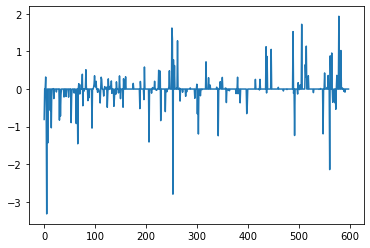

In [378]:
plt.plot(samples['delta'][0][:,0])

In [283]:
# samples = sample_from_model(model, {'init_weight': get_coefs_for_numpyro('stim0')}, z_sample=['y', 'stimulated_weights', 'logits'], num_samples=1, X=OFFERS)

In [359]:
samples['learning_rate']

[array([0.06368997, 0.00227073, 0.25205383], dtype=float32)]

In [285]:
samples['true_weight_mean_prior_mean']

[array([0.5111579 , 2.276132  , 0.23958682], dtype=float32)]

In [286]:
samples['true_weight_mean_prior_scale']

[array([0.02543803, 0.4174473 , 1.7843424 ], dtype=float32)]

In [287]:
samples['repetition_kernel']

[array([0.7978287], dtype=float32)]

In [288]:
samples['true_weight_mean']

[array([[ 0.51636964,  2.024768  ,  1.2593937 ],
        [ 0.50178456,  2.426499  ,  1.634726  ],
        [ 0.5001851 ,  2.658059  , -0.98112226]], dtype=float32)]

In [379]:
samples['y']

[array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [290]:
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer import Predictive

In [308]:
optimizer = numpyro.optim.Minimize()
guide = AutoDelta(model)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
init_state = svi.init(jax.random.PRNGKey(0), X=OFFERS, stage=STAGE, y=samples['y'][0])
state = init_state
# for i in range(3):
state, loss = svi.update(state, X=OFFERS, stage=STAGE, y=samples['y'][0])
params = svi.get_params(state)  # get guide's parameters

(599, 3)
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
(599, 3)
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
(599, 3)
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=3/0)>
(599, 3)
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
(599, 3)
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
(599, 3)
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=3/0)>
(599, 3)
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=5/0)>
(599, 3)
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=6/0)>
(599, 3)
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=6/0)>


In [309]:
guide_samples = guide.sample_posterior(jax.random.PRNGKey(2), params)
predictive = Predictive(model, guide_samples, guide=guide, batch_ndims=0)
all_params = predictive(jax.random.PRNGKey(2), X=OFFERS, stage=STAGE, y=samples['y'][0])

(599, 3)
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>


In [360]:
def fit(model, num_chains, num_warmup=1000, num_samples=1000, rng_seed=0, **kwargs):
    #     assert set(kwargs.keys()) <= set(model.__code__.co_varnames), model.__code__.co_varnames
    #     assert (('X' in kwargs.keys() or 'Xs' in kwargs.keys()) and ('y' in kwargs.keys()))
    nuts_kernel = NUTS(model, adapt_step_size=True)
    mcmc = MCMC(
        nuts_kernel,
        num_chains=num_chains,
        num_warmup=num_warmup,
        num_samples=num_samples,
    )
    rng_key = jax.random.PRNGKey(rng_seed)
#     with numpyro.validation_enabled():
    mcmc.run(rng_key, **kwargs)
    return mcmc, az.from_numpyro(mcmc)

In [380]:
mcmc, idata = fit(model, 1, X=OFFERS, stage=STAGE, y=samples['y'][0])

(599, 3)
[[ 0.27738667 -0.08904362 -1.9022222 ]
 [ 0.6564388  -1.3018713  -0.62197876]
 [ 1.1920972  -2.872539    0.33317423]]
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
(599, 3)
Traced<ConcreteArray([[ 0.24941397  1.7944293  -1.2579994 ]
 [ 1.5487547   2.085175    0.63744116]
 [ 2.0170856   1.4497232   1.3451242 ]])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([[ 0.24941397,  1.7944293 , -1.2579994 ],
                             [ 1.5487547 ,  2.085175  ,  0.63744116],
                             [ 2.0170856 ,  1.4497232 ,  1.3451242 ]], dtype=float32)
       tangent = Traced<ShapedArray(float32[3,3]):JaxprTrace(level=1/0)>
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=3/0)>
(599, 3)
Traced<ShapedArray(float32[3,3])>with<JVPTrace(level=3/0)>
  with primal = Traced<ShapedArray(float32[3,3])>with<DynamicJaxprTrace(level=1/0)>
       tangent = Traced<ShapedArray(float32[3,3]):JaxprTrace(level=2/0)>
Traced<ShapedArray(float32[3])>with<Dynami

  0%|          | 0/2000 [00:00<?, ?it/s]

(599, 3)
Traced<ShapedArray(float32[3,3])>with<JVPTrace(level=4/1)>
  with primal = Traced<ShapedArray(float32[3,3])>with<DynamicJaxprTrace(level=2/1)>
       tangent = Traced<ShapedArray(float32[3,3]):JaxprTrace(level=3/1)>
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=5/1)>


sample: 100%|██████████| 2000/2000 [01:13<00:00, 27.34it/s, 31 steps of size 1.21e-01. acc. prob=0.91] 


(599, 3)
Traced<ShapedArray(float32[3,3])>with<DynamicJaxprTrace(level=1/1)>
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/1)>
(599, 3)
[[ 1.1378783  -1.220955   -0.59153646]
 [ 1.0718056  -1.0541893   0.58646697]
 [-1.13334    -1.9609755   0.07593244]]
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
(599, 3)
Traced<ShapedArray(float32[3,3])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>


In [381]:
mcmc.print_summary()


                                   mean       std    median      5.0%     95.0%     n_eff     r_hat
               forget_rate[0]      0.48      0.28      0.47      0.04      0.92    738.48      1.00
               forget_rate[1]      0.49      0.30      0.49      0.01      0.91   1579.04      1.00
       initial_weight_base[0]     -1.04      0.66     -1.02     -2.08      0.11    776.30      1.00
       initial_weight_base[1]      1.30      0.58      1.31      0.39      2.26    453.76      1.00
       initial_weight_base[2]     -0.17      0.72     -0.17     -1.39      0.97    863.70      1.00
             learning_rate[0]      0.08      0.04      0.08      0.01      0.14    457.12      1.00
             learning_rate[1]      0.01      0.01      0.01      0.00      0.02    817.32      1.00
             learning_rate[2]      0.09      0.04      0.09      0.02      0.16    573.13      1.00
perseverance_growth_rate[0,0]      7.36      5.60      5.86      0.00     15.06   1038.86      1.00

In [382]:
def compute_accuracy(idata, with_lapse=False):
    y = np.array(idata.observed_data.y)
    if with_lapse:
        probs = np.mean(np.array(idata.posterior.probs_with_lapse), axis=(0, 1))
    else:
        logits = np.array(idata.posterior.logits)
        probs = np.mean(jax.nn.sigmoid(logits), axis=(0, 1))
    accuracy = np.mean((probs >= 0.5) == y)
    return accuracy

In [383]:
compute_accuracy(idata)

DeviceArray(0.884808, dtype=float32)

In [384]:
compute_accuracy(idata, with_lapse=True)

0.8848080133555927

In [385]:
loo_orig = az.loo(idata, pointwise=True)
loo_orig

Computed from 1000 by 599 log-likelihood matrix

         Estimate       SE
elpd_loo  -191.21    14.92
p_loo       10.42        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      599  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [333]:
sum(loo_orig.pareto_k > 0.7)

<xarray.DataArray 'pareto_shape' ()>
array(1)
Coordinates:
    y_dim_0  int64 598

In [334]:
test_indices = [0, 42]

In [335]:
loo_orig.pareto_k[test_indices] = np.array([0.8, 1.2])

In [337]:
loo_relooed = compute_reloo(model, mcmc, loo_orig=loo_orig, X=OFFERS, stage=STAGE)

Pareto-k over 0.7 for <xarray.DataArray 'pareto_shape' ()>
array(3) points.
1
{'X': array([[-0.66509851, -0.32044912],
       [-0.285807  , -1.64016379],
       [ 1.43824531, -0.21626112],
       ...,
       [-1.28575734, -0.73720112],
       [-1.49264362,  1.38128821],
       [-1.56160572, -0.80665979]]), 'y': array([-1,  0,  1,  0,  0,  0,  1,  0,  1,  1,  1,  1,  1,  0,  1,  1,  1,
        1,  1,  0,  1,  1,  1,  0,  0,  1,  0,  0,  0,  1,  1,  1,  0,  0,
        1,  1,  0,  1,  1,  0,  1,  0,  1,  1,  0,  1,  0,  1,  0,  1,  1,
        1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  1,  1,  1,  1,  1,  0,  0,
        0,  1,  1,  0,  0,  0,  0,  1,  0,  0,  1,  0,  1,  1,  0,  1,  1,
        1,  0,  1,  1,  1,  1,  0,  1,  1,  0,  0,  0,  0,  0,  1,  0,  0,
        1,  0,  0,  0,  1,  1,  1,  1,  1,  0,  1,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  1,  0,  1,  0,  1,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  1,  1,
        0,  

/Users/julianstastny/miniconda3/envs/mastersthesis/lib/python3.9/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
sample: 100%|██████████| 200/200 [00:33<00:00,  5.97it/s, 63 steps of size 6.38e-02. acc. prob=0.93]



                                   mean       std    median      5.0%     95.0%     n_eff     r_hat
              AR(1)_base[0,0]      0.06      1.02      0.05     -1.19      1.76     64.25      1.01
              AR(1)_base[0,1]     -0.06      1.05      0.01     -1.51      1.68    184.04      0.99
              AR(1)_base[0,2]      0.07      0.93      0.11     -1.42      1.52     96.07      1.00
              AR(1)_base[1,0]     -0.05      0.98     -0.02     -1.32      1.88    124.75      0.99
              AR(1)_base[1,1]      0.13      1.12      0.23     -1.38      2.10     86.95      1.03
              AR(1)_base[1,2]     -0.19      0.98     -0.19     -1.53      1.53     82.84      1.00
              AR(1)_base[2,0]      0.22      1.14      0.29     -1.67      1.90     99.71      0.99
              AR(1)_base[2,1]      0.04      1.00      0.11     -1.48      1.53    124.25      1.01
              AR(1)_base[2,2]     -0.01      0.94      0.03     -1.75      1.34    119.98      0.99

sample: 100%|██████████| 200/200 [00:33<00:00,  5.92it/s, 31 steps of size 1.07e-01. acc. prob=0.75] 



                                   mean       std    median      5.0%     95.0%     n_eff     r_hat
              AR(1)_base[0,0]      0.14      0.93      0.19     -1.19      1.84     78.28      1.02
              AR(1)_base[0,1]      0.02      0.99      0.01     -1.45      1.59     99.28      0.99
              AR(1)_base[0,2]      0.05      0.99      0.16     -1.89      1.18    110.33      1.00
              AR(1)_base[1,0]      0.07      1.03      0.10     -1.52      1.81     92.40      1.00
              AR(1)_base[1,1]     -0.06      0.93      0.07     -1.20      1.61     78.36      0.99
              AR(1)_base[1,2]      0.01      0.86     -0.04     -1.17      1.48     83.55      1.00
              AR(1)_base[2,0]      0.13      0.95      0.15     -1.25      1.91    122.70      0.99
              AR(1)_base[2,1]     -0.14      0.96     -0.07     -1.38      1.59    120.09      0.99
              AR(1)_base[2,2]      0.13      0.92      0.01     -1.38      1.57     98.15      0.99

sample: 100%|██████████| 200/200 [00:30<00:00,  6.55it/s, 63 steps of size 6.43e-02. acc. prob=0.92] 



                                   mean       std    median      5.0%     95.0%     n_eff     r_hat
              AR(1)_base[0,0]     -0.00      0.81     -0.04     -1.23      1.24    183.08      1.00
              AR(1)_base[0,1]     -0.01      0.96     -0.07     -1.42      1.61    141.59      0.99
              AR(1)_base[0,2]     -0.03      1.28     -0.05     -1.84      2.36    410.26      0.99
              AR(1)_base[1,0]     -0.03      1.01      0.09     -1.77      1.49    321.29      0.99
              AR(1)_base[1,1]      0.02      1.03     -0.03     -1.43      1.87    177.31      0.99
              AR(1)_base[1,2]     -0.14      0.79     -0.08     -1.38      1.22     93.96      0.99
              AR(1)_base[2,0]      0.12      1.07      0.16     -1.44      1.98    168.02      0.99
              AR(1)_base[2,1]      0.01      0.75      0.02     -1.36      1.04    135.87      0.99
              AR(1)_base[2,2]     -0.07      1.02     -0.16     -1.70      1.63    193.33      1.00

In [338]:
print(loo_orig.loo_i[test_indices])
print(loo_relooed.loo_i[test_indices])

<xarray.DataArray 'loo_i' (y_dim_0: 2)>
array([-0.59764481, -0.55648756])
Coordinates:
  * y_dim_0  (y_dim_0) int64 0 42
<xarray.DataArray 'loo_i' (y_dim_0: 2)>
array([-0.61917353, -0.53228951])
Coordinates:
  * y_dim_0  (y_dim_0) int64 0 42


In [339]:
loo_orig

Computed from 2000 by 599 log-likelihood matrix

         Estimate       SE
elpd_loo  -270.72    13.17
p_loo       10.25        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      592   98.8%
 (0.5, 0.7]   (ok)          4    0.7%
   (0.7, 1]   (bad)         2    0.3%
   (1, Inf)   (very bad)    1    0.2%

In [340]:
loo_relooed

Computed from 2000 by 599 log-likelihood matrix

         Estimate       SE
elpd_loo  -270.71    13.17
p_loo       10.24        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      595   99.3%
 (0.5, 0.7]   (ok)          4    0.7%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

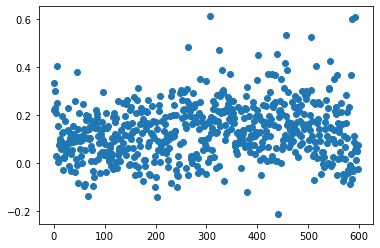

In [286]:
plt.scatter(np.arange(len(loo.pareto_k)), loo.pareto_k)

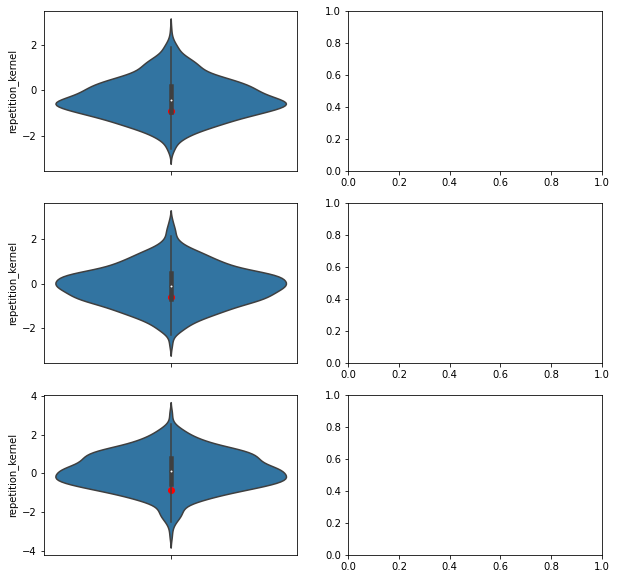

In [390]:
fig, axes = plt.subplots(3, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
for i in range(3):
#     for j in range(2):
#         sns.violinplot(y=idata.posterior.repetition_kernel[...,i, j], ax=axes[i, j])
#         axes[i, j].scatter(x=[0], y=[samples['repetition_kernel'][0][i, j]], color='r')
    sns.violinplot(y=idata.posterior.repetition_kernel[...,i], ax=axes[i, j])
    axes[i, j].scatter(x=[0], y=[samples['repetition_kernel'][0][i]], color='r')

AttributeError: 'Dataset' object has no attribute 'alpha'

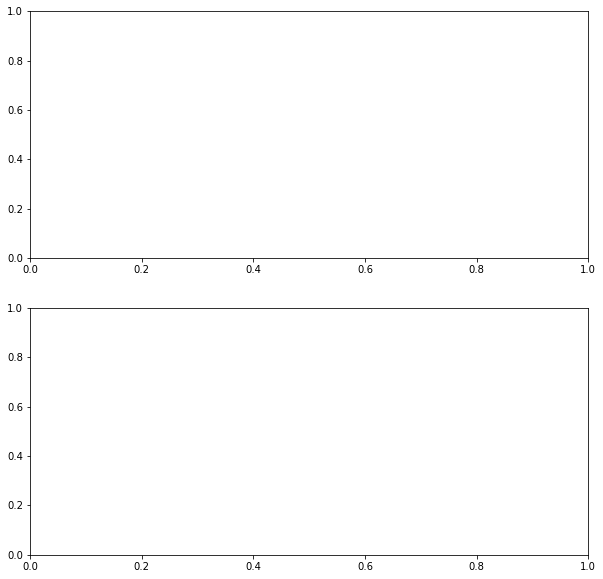

In [307]:
fig, axes = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(10)
for i in range(2):
    sns.violinplot(y=idata.posterior.alpha[...,i], ax=axes[i])
    axes[i].scatter(x=[0], y=[samples['alpha'][0][i]], color='r')

ValueError: x and y must be the same size

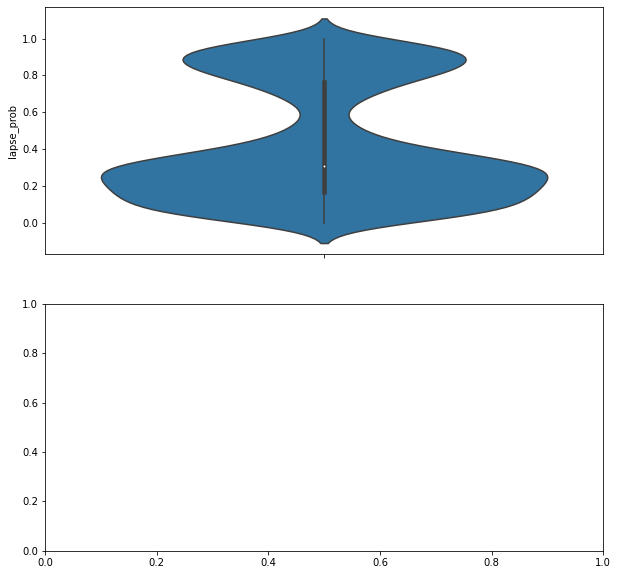

In [289]:
fig, axes = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(10)
sns.violinplot(y=idata.posterior.lapse_prob, ax=axes[0])
axes[0].scatter(x=[0], y=[samples['lapse_prob'][0]], color='r')
sns.violinplot(y=idata.posterior.approach_given_lapse, ax=axes[1])
axes[1].scatter(x=[0], y=[samples['approach_given_lapse'][0]], color='r')

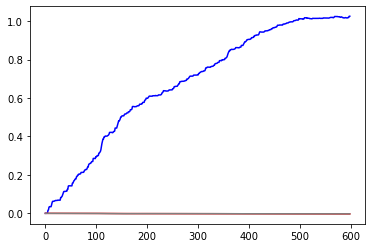

In [367]:
plt.plot(all_params['AR(1) with learning'][:,0], alpha=1, color='b'); # Blue = reward weights
plt.plot(all_params['AR(1) with learning'][:,1], alpha=1, color='r'); # Red = aversion weights
plt.plot(all_params['AR(1) with learning'][:,2], alpha=1, color='grey'); # Grey = intercept

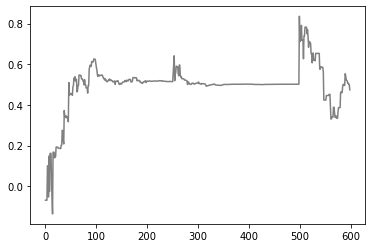

In [301]:
plt.plot(samples['stimulated_weights'][0][:,0], alpha=1, color='grey'); # Grey = intercept

In [302]:
max(samples['stimulated_weights'][0].flatten())

2.5826979

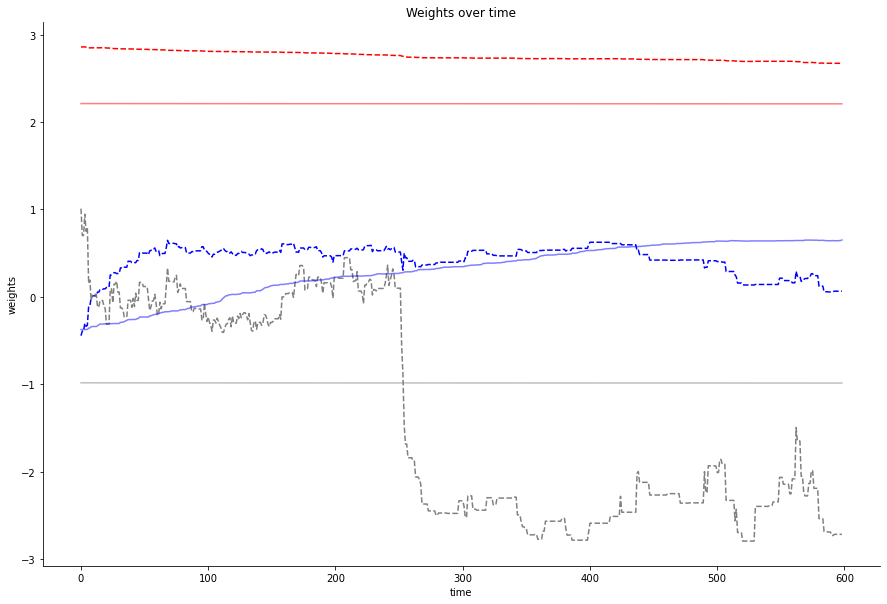

In [368]:
fig = plt.figure(figsize=(15, 10))
plt.plot(samples['stimulated_weights'][0][:,0], alpha=1, color='b', linestyle='--'); # Blue = reward weights
plt.plot(samples['stimulated_weights'][0][:,1], alpha=1, color='r', linestyle='--'); # Red = aversion weights
plt.plot(samples['stimulated_weights'][0][:,2], alpha=1, color='grey', linestyle='--'); # Grey = intercept

plt.plot(all_params['stimulated_weights'][:,0], alpha=0.5, color='b'); # Blue = reward weights
plt.plot(all_params['stimulated_weights'][:,1], alpha=0.5, color='r'); # Red = aversion weights
plt.plot(all_params['stimulated_weights'][:,2], alpha=0.5, color='grey'); # Grey = intercept


plt.xlabel('time'); plt.ylabel('weights'); plt.title('Weights over time'); sns.despine();

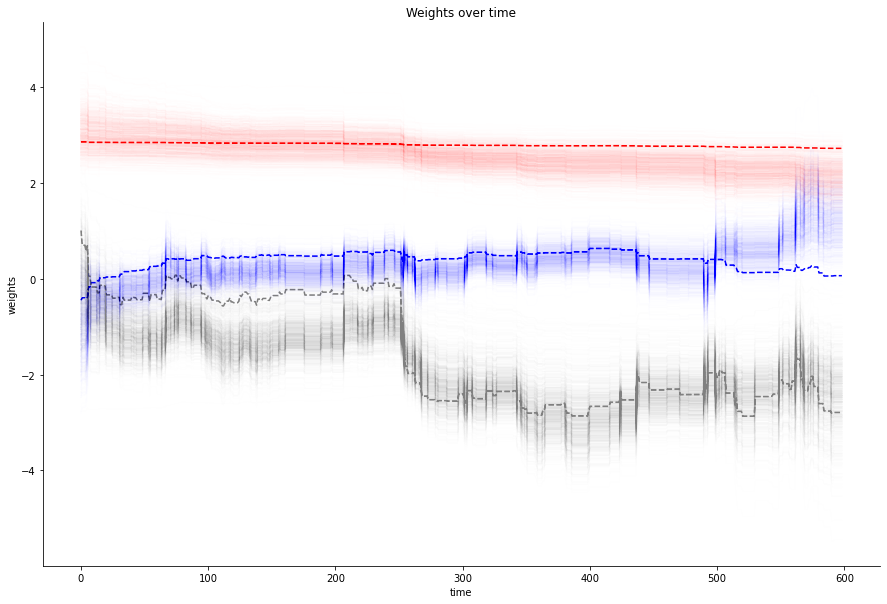

In [386]:
fig = plt.figure(figsize=(15, 10))
plt.plot(samples['stimulated_weights'][0][:,0], alpha=1, color='b', linestyle='--'); # Blue = reward weights
plt.plot(samples['stimulated_weights'][0][:,1], alpha=1, color='r', linestyle='--'); # Red = aversion weights

plt.plot(samples['stimulated_weights'][0][:,2], alpha=1, color='grey', linestyle='--'); # Grey = intercept

plt.plot(np.concatenate(idata['posterior']['stimulated_weights'], axis=0)[:1000][:, :, 0].T, alpha=.005, color='b'); # Blue = reward weights
plt.plot(np.concatenate(idata['posterior']['stimulated_weights'], axis=0)[:1000][:, :, 1].T, alpha=.005, color='r'); # Red = aversion weights
plt.plot(np.concatenate(idata['posterior']['stimulated_weights'], axis=0)[:1000][:, :, 2].T, alpha=.005, color='grey'); # Grey = intercept


plt.xlabel('time'); plt.ylabel('weights'); plt.title('Weights over time'); sns.despine();

In [387]:
def plot_psychometric_function(logits):
    fig = plt.figure(figsize=(10, 5))
    probs = jax.nn.sigmoid(logits)
    lims = np.max(np.abs(logits))
    xrange = np.linspace(-lims, lims, 1000)
    sigma = jax.nn.sigmoid(xrange)
    plt.plot(xrange, sigma, color='black')
    plt.scatter(logits, probs, c=logits>0, cmap='bwr_r')

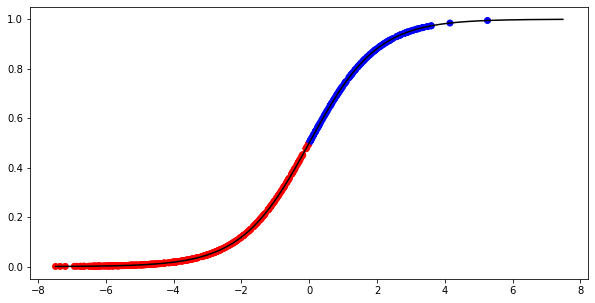

In [388]:
plot_psychometric_function(np.mean(idata.posterior.logits, axis=1)[-1])

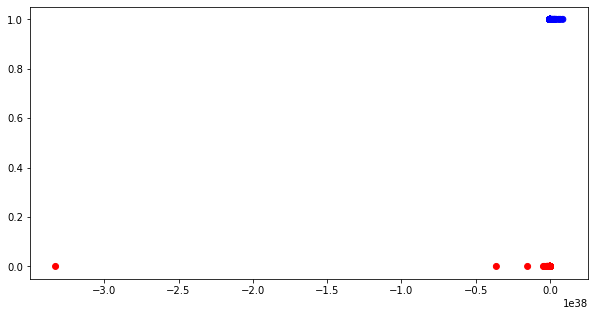

In [181]:
plot_psychometric_function(all_params['logits'])

In [133]:
plot_psychometric_function(samples['logits'][0])

KeyError: 'logits'